# Problem Statement

Create a 100x100 grid with obstacles in between 2 random points. Build an MDP based RL agent to optimise both policies and actions at every state. Benchmark DP method with other RL solutions for the same problem.

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Grid Creation 

In [13]:
def create_grid(size, obstacle_ratio):
    grid = np.zeros((size, size))
    num_obstacles = int(size * size * obstacle_ratio)
    obstacle_indices = np.random.choice(size * size, num_obstacles, replace=False)

    for index in obstacle_indices:
        x, y = divmod(index, size)
        grid[x, y] = 1
    return grid

## Random Point Generation

In [14]:
def get_random_point(grid):
    while True:
        x, y = np.random.randint(0, grid.shape[0], size=2)
        if grid[x, y] == 0:
            return (x, y)

## Q-Learning Agent Class 

In [15]:
class QLearningAgent:
    def __init__(self, grid, start, goal, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.grid = grid
        self.start = start
        self.goal = goal
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((grid.shape[0], grid.shape[1], len(actions)))

    def next_state(self, state, action):
        x, y = state
        if action == 0:
            next_state = (max(0, x - 1), y)
        elif action == 1:
            next_state = (min(grid.shape[0] - 1, x + 1), y)
        elif action == 2:
            next_state = (x, max(0, y - 1))
        elif action == 3:
            next_state = (x, min(grid.shape[1] - 1, y + 1))

        if self.grid[next_state] == 1:
            return state
        return next_state

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(len(self.actions)))
        return np.argmax(self.q_table[state])

    def update_q(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_delta

    def train(self, episodes):
        for episode in range(episodes):
            state = self.start
            while state != self.goal:
                action = self.choose_action(state)
                next_state = self.next_state(state, action)
                reward = 1 if next_state == self.goal else -0.1
                self.update_q(state, action, reward, next_state)
                state = next_state

## Value Iteration Function 

In [18]:
def value_iterate(grid, start, goal, actions, theta=0.01):
    V = np.zeros((grid.shape[0], grid.shape[1]))
    while True:
        delta = 0
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                if grid[x, y] == 1:
                    continue
                v = V[x, y]
                V[x, y] = max([sum([0 if (nx, ny) == (x, y) else (1 if (nx, ny) == goal else -0.1)
                                     for (nx, ny) in get_moves(x, y)]) 
                               for (dx, dy) in actions])
                delta = max(delta, abs(v - V[x, y]))
        if delta < theta:
            break
    return V

## Moves Calculation 

In [19]:
def get_moves(x, y):
    moves = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < grid_size and 0 <= ny < grid_size and grid[nx, ny] == 0:
            moves.append((nx, ny))
    return moves

## Grid Plotting 

In [20]:
def plot_grid(grid, start, goal, q_values):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray', interpolation='nearest')

    plt.scatter(start[1], start[0], color='blue', s=500, label='Start', edgecolor='black')
    plt.scatter(goal[1], goal[0], color='red', s=500, label='Goal', edgecolor='black')

    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if grid[x, y] == 1:
                continue
            plt.text(y, x, f'{np.argmax(q_values[x, y])}', ha='center', va='center', color='white')

    plt.title('Grid with Start, Goal, and Q-Values')
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.show()

In [21]:
grid_size = 100
obstacle_ratio = 0.2
actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
grid = create_grid(grid_size, obstacle_ratio)
start = get_random_point(grid)
goal = get_random_point(grid)

agent = QLearningAgent(grid, start, goal, actions)
agent.train(1000)

optimal_values = value_iterate(grid, start, goal, actions)

Learned Q-values:
[[[ 0.          0.          0.          0.        ]
  [-0.80789345 -0.80728067 -0.80689017 -0.80869589]
  [-0.80875787 -0.81007803 -0.80703896 -0.81024719]
  ...
  [-0.60148443 -0.60332408 -0.60240713 -0.60062181]
  [-0.60234617 -0.60048868 -0.6027554  -0.59926413]
  [ 0.          0.          0.          0.        ]]

 [[-0.80906372 -0.81000822 -0.80978648 -0.80927852]
  [-0.80816435 -0.80988606 -0.80920797 -0.80732093]
  [-0.80868627 -0.80848452 -0.80791099 -0.80910104]
  ...
  [-0.60187963 -0.60183543 -0.60340186 -0.6028903 ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[-0.80960637 -0.81007389 -0.8101342  -0.81062842]
  [-0.81033399 -0.81075684 -0.80954137 -0.81055285]
  [ 0.          0.          0.          0.        ]
  ...
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 ...

 [[-0.75884267 -

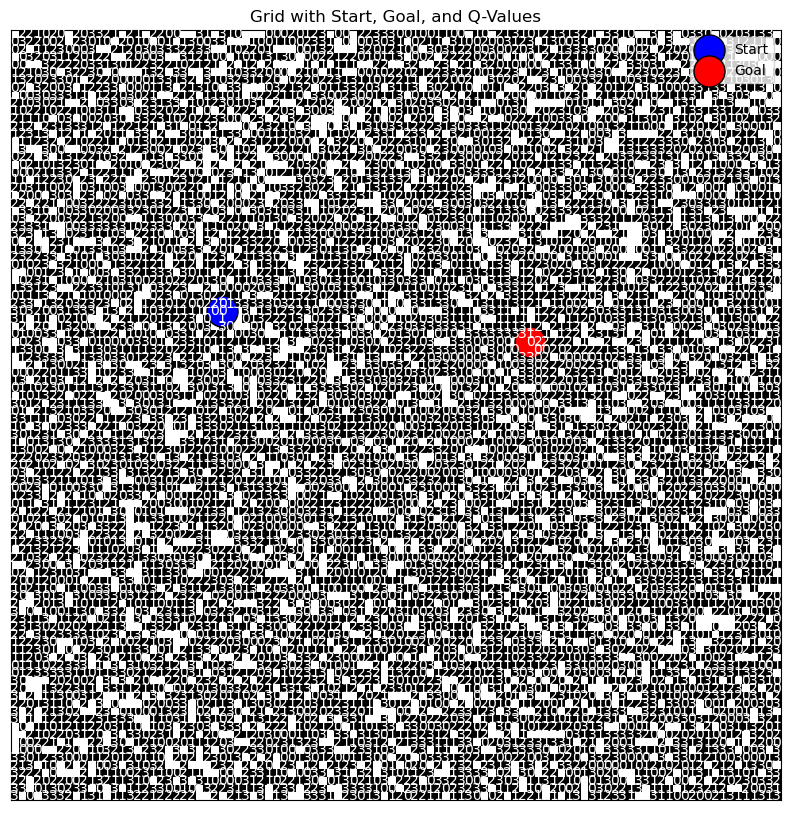

In [22]:
print("Learned Q-values:")
print(agent.q_table)
print("Optimal Values:")
print(optimal_values)

plot_grid(grid, start, goal, agent.q_table)